In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
dj.config['database.host'] = 'datajoint.mesoscale-activity-map.org'
dj.config['database.user'] = 'pochen'
dj.config['database.password'] = 'simple'

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util

Connecting pochen@datajoint.mesoscale-activity-map.org:3306


# Plan
### Fetch population data
### Coding dimension analysis
### dsPCA




## Fetch population data

In [2]:
# after unit qc
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:]

,count
annotation,
"Lateral septal nucleus, rostral (rostroventral) part",801
Caudoputamen,473
"Secondary motor area, layer 6a",401
"Secondary motor area, layer 5",294
"Prelimbic area, layer 5",286
...,...
Ethmoid nucleus of the thalamus,1
"Retrosplenial area, ventral part, layer 6a",1
Triangular nucleus of septum,1


In [24]:
lab.WaterRestriction() & 'water_restriction_number LIKE "HH%"'

subject_id institution 6 digit animal ID,water_restriction_number WR number,cage_number,wr_start_date,wr_start_weight
472184,HH07,176952,2020-08-24,30.000
472195,HH01,176954,2020-07-29,28.300
473359,HH06,177549,2020-08-24,27.100
473360,HH08,177549,2020-10-20,25.700
473361,HH09,177549,2020-10-20,25.600
473611,HH04,177643,2020-08-11,18.600
482350,HH11,182525,2020-11-19,25.400
482352,HH12,187449,2021-06-08,37.300
482353,HH13,187450,2021-06-08,32.400
482354,HH10,182526,2020-11-19,19.300


In [3]:
def select_unit_qc_region(all_unit_qc, region="Prelimbic%"):
    return (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "{}"'.format(region)

def unique_session_in_region(unit_qc_region, region):
    print('total number of units in the region {}: {}'.format(region, len(unit_qc_region)))
    print(' unique sessions: {}'.format(np.unique(unit_qc_region.fetch('session'))))
    session_unit_cts = {}
    for session in np.unique(unit_qc_region.fetch('session')):
        session_unit_cts[session] = np.sum(unit_qc_region.fetch('session')==session)
        print(' session {}: {}'.format(session, np.sum(unit_qc_region.fetch('session')==session)))
    return session_unit_cts

def select_unit_qc_region_mouse_session(all_unit_qc, region="Prelimbic%", mouse="HH09", session=47):
    unit_qc_region = select_unit_qc_region(all_unit_qc, region=region)
    return unit_qc_region & (lab.WaterRestriction & 'water_restriction_number = "{}"'.format(mouse)) & 'session = {}'.format(session)


# prelimbic: 
region, mouse, session = "Prelimbic%", "HH09", 47
# Lateral septal nucleus, rostral (rostroventral) part
# region, mouse, session ="Lateral septal nucleus, rostral (rostroventral) part", "HH08", 49
# Secondary motor area, layer 6a
# region, mouse, session ="Secondary motor area, layer 6a", "HH09", 50
# Caudoputamen
# region, mouse, session ="Caudoputamen", "HH13", 45


# select qc unit in region
# region = "Caudoputamen"
unit_qc_region = select_unit_qc_region(all_unit_qc, region=region)
session_unit_cts = unique_session_in_region(unit_qc_region, region=region)

# select qc in region, by mouse and session
# region = "Caudoputamen"
# session = 45
subject_id = np.unique((unit_qc_region & 'session={}'.format(session)).fetch('subject_id'))
if len(subject_id) == 1:
    mouse = (lab.WaterRestriction() & 'subject_id={}'.format(subject_id[0])).fetch('water_restriction_number')[0]
    print('mouse: {}'.format(mouse))

unit_qc_region_mouse_session = select_unit_qc_region_mouse_session(all_unit_qc, region=region, mouse=mouse, session=session)
print('total number of units in {} by mouse {} by session {}: {}'.format(region, mouse, session, len(unit_qc_region_mouse_session)))

total number of units in the region Prelimbic%: 409
 unique sessions: [34 36 37 46 47 48 49 50 51 52]
 session 34: 17
 session 36: 19
 session 37: 3
 session 46: 46
 session 47: 58
 session 48: 45
 session 49: 76
 session 50: 48
 session 51: 4
 session 52: 93
mouse: HH09
total number of units in Prelimbic% by mouse HH09 by session 47: 58


In [4]:
# fetch population activities

def gen_keys2units(unit_qc_region_mouse_session, check_laterality=True):
    
    # get all keys
    keys2units = unit_qc_region_mouse_session.fetch('KEY')
    print('num of units: {}'.format(len(keys2units)))

    # check the laterality of units
    if check_laterality:
        hemi = util._get_units_hemisphere(keys2units)
        print('laterality: {}'.format(hemi))
    return keys2units


def gen_keys2trials(keys2units):
    
    # fetch trials in the session
    # print(psth_foraging.TrialCondition().fetch('trial_condition_name'))
    # psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
    keys2trials_all = (psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units).fetch('KEY')
    trials_all = psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
    print('num of all trials: {}'.format(len(keys2trials_all)))

    keys2trials_L = (psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units).fetch('KEY')
    trials_L = psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units
    print('num of left trials: {}'.format(len(keys2trials_L)))

    keys2trials_R = (psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units).fetch('KEY')
    trials_R = psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units
    print('num of right trials: {}'.format(len(keys2trials_R)))

    keys2trials_hit = (psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units).fetch('KEY')
    trials_hit = psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units
    print('num of hit trials: {}'.format(len(keys2trials_hit)))

    keys2trials_miss = (psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units).fetch('KEY')
    trials_miss = psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units
    print('num of miss trials: {}'.format(len(keys2trials_miss)))

    return [keys2trials_all, keys2trials_L, keys2trials_R, keys2trials_hit, keys2trials_miss], [trials_all, trials_L, trials_R, trials_hit, trials_miss]


keys2units = gen_keys2units(unit_qc_region_mouse_session, check_laterality=True)
[keys2trials_all, keys2trials_L, keys2trials_R, keys2trials_hit, keys2trials_miss], [trials_all, trials_L, trials_R, trials_hit, trials_miss] = gen_keys2trials(keys2units)

num of units: 58
laterality: right
num of all trials: 408
num of left trials: 233
num of right trials: 175
num of hit trials: 135
num of miss trials: 273


In [5]:
def gen_psth_per_trial(keys2units, trials, align_type='iti_start'):
    
    pop_psth_per_trial = []
    trial_ind = []
    bins = None
    for key in keys2units:
        unit_psth_raster = psth_foraging.compute_unit_psth_and_raster(key, trials, align_type)
        unit_psth_per_trial = unit_psth_raster['psth_per_trial']  # (trial, time_step)
        pop_psth_per_trial.append(unit_psth_per_trial)
        if bins is None:
            bins = unit_psth_raster['bins']
    pop_psth_per_trial = np.array(pop_psth_per_trial)
    print('bins: {}'.format(bins.shape))
    print('population psth per trial: {}'.format(pop_psth_per_trial.shape))

    return bins, pop_psth_per_trial


def get_psth_by_trial_type_index(pop_psth, all_trial_ind, select_trial_ind):
    
    select_index = np.where(np.in1d(all_trial_ind, select_trial_ind))[0]
    pop_psth_selected_trial = pop_psth[:, select_index, :]
    print('check: sel trial ind {}, output pop psth {}'.format(select_trial_ind.shape, pop_psth_selected_trial.shape))
    
    return pop_psth_selected_trial


bins, pop_psth_all = gen_psth_per_trial(keys2units, trials_all)  # (unit, trial, time_step)

all_trial_ind = np.array(trials_all.fetch('trial'))
left_trial_ind = np.array((trials_all & 'water_port="left"').fetch('trial'))
right_trial_ind = np.array((trials_all & 'water_port="right"').fetch('trial'))
hit_trial_ind = np.array((trials_all & 'outcome="hit"').fetch('trial'))
miss_trial_ind = np.array((trials_all & 'outcome="miss"').fetch('trial'))


pop_psth_L = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, left_trial_ind)
pop_psth_R = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, right_trial_ind)

pop_psth_hit = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, hit_trial_ind)
pop_psth_miss = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, miss_trial_ind)

bins: (324,)
population psth per trial: (58, 408, 324)
check: sel trial ind (233,), output pop psth (58, 233, 324)
check: sel trial ind (175,), output pop psth (58, 175, 324)
check: sel trial ind (135,), output pop psth (58, 135, 324)
check: sel trial ind (273,), output pop psth (58, 273, 324)


## Coding Axes

(58, 175, 324)
(58, 233, 324)


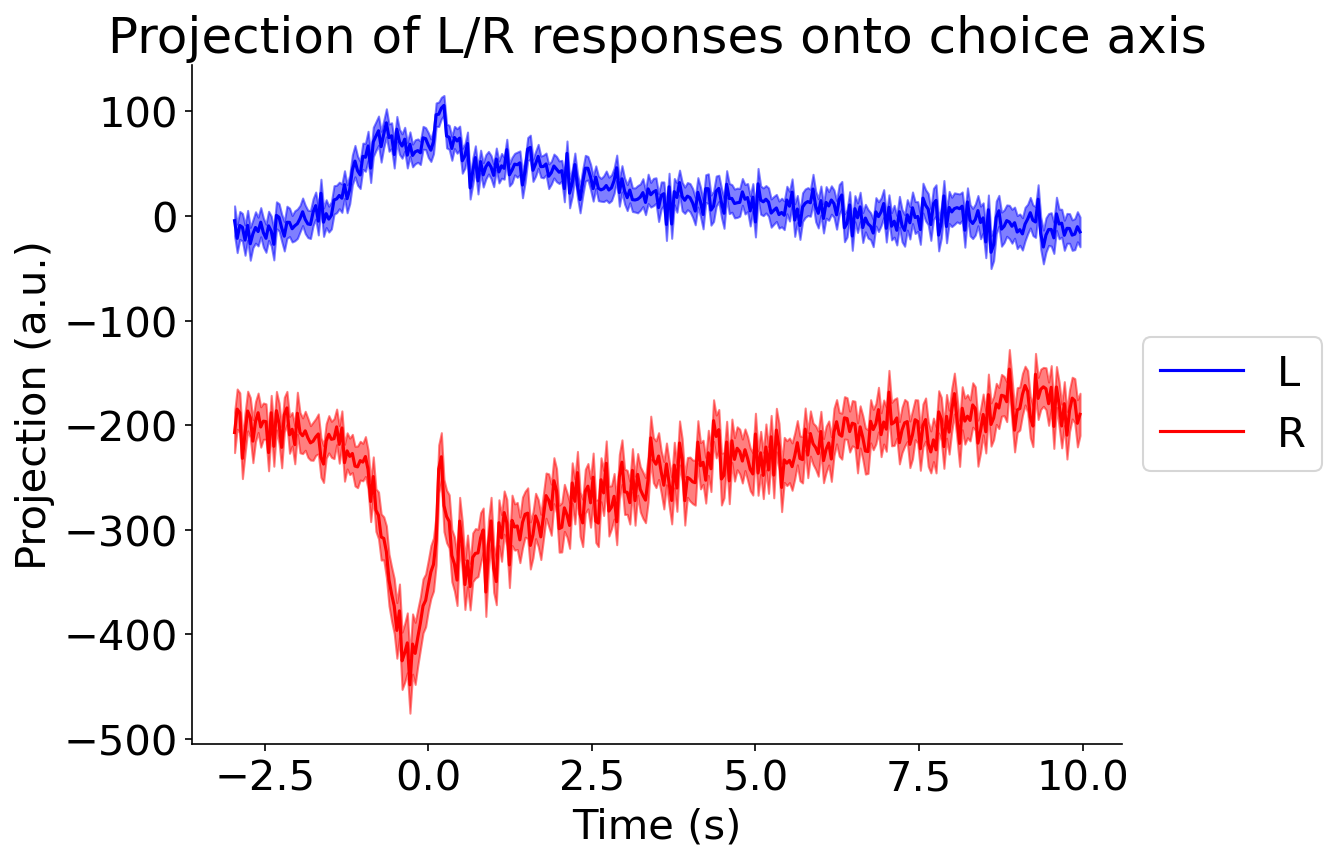

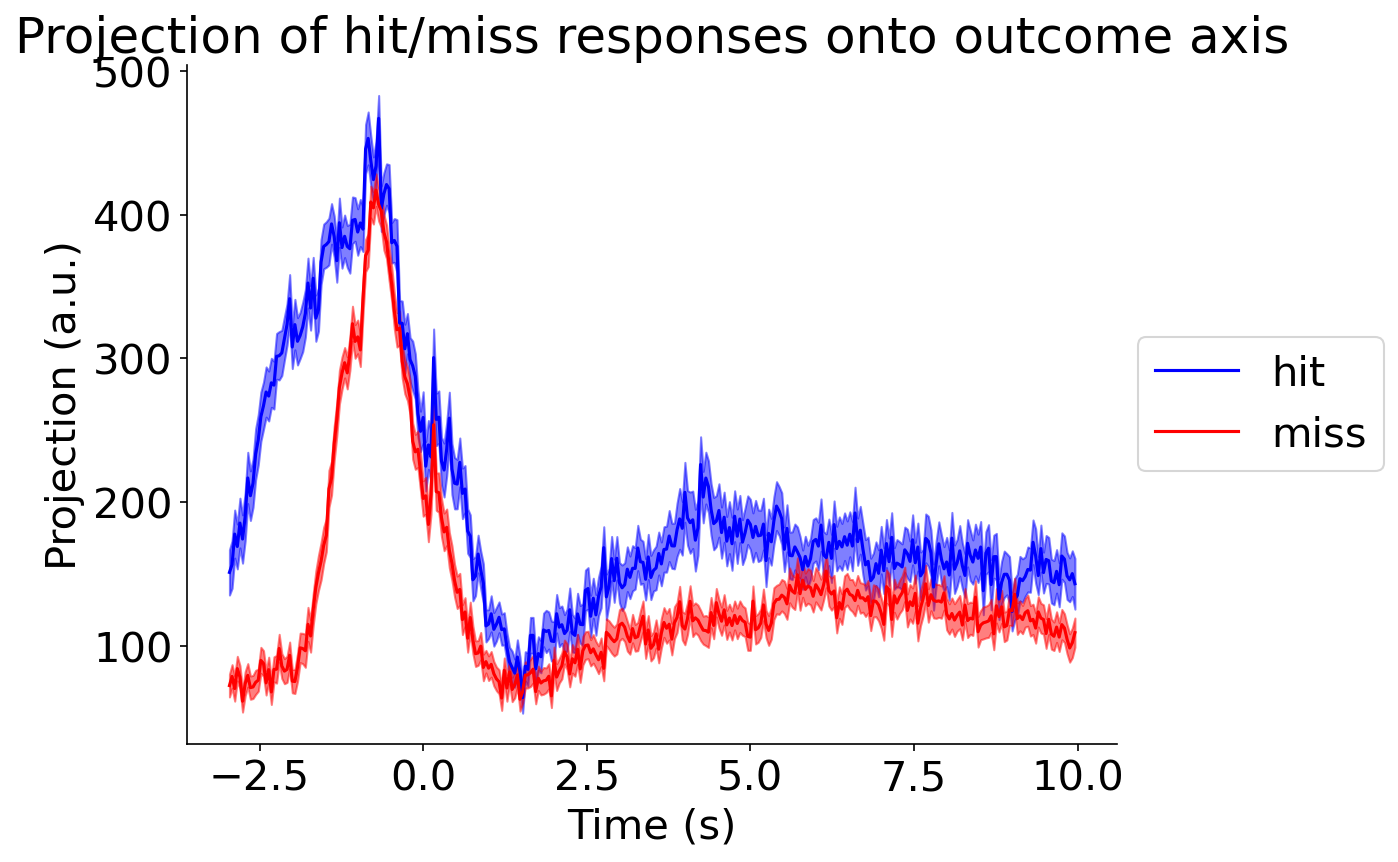

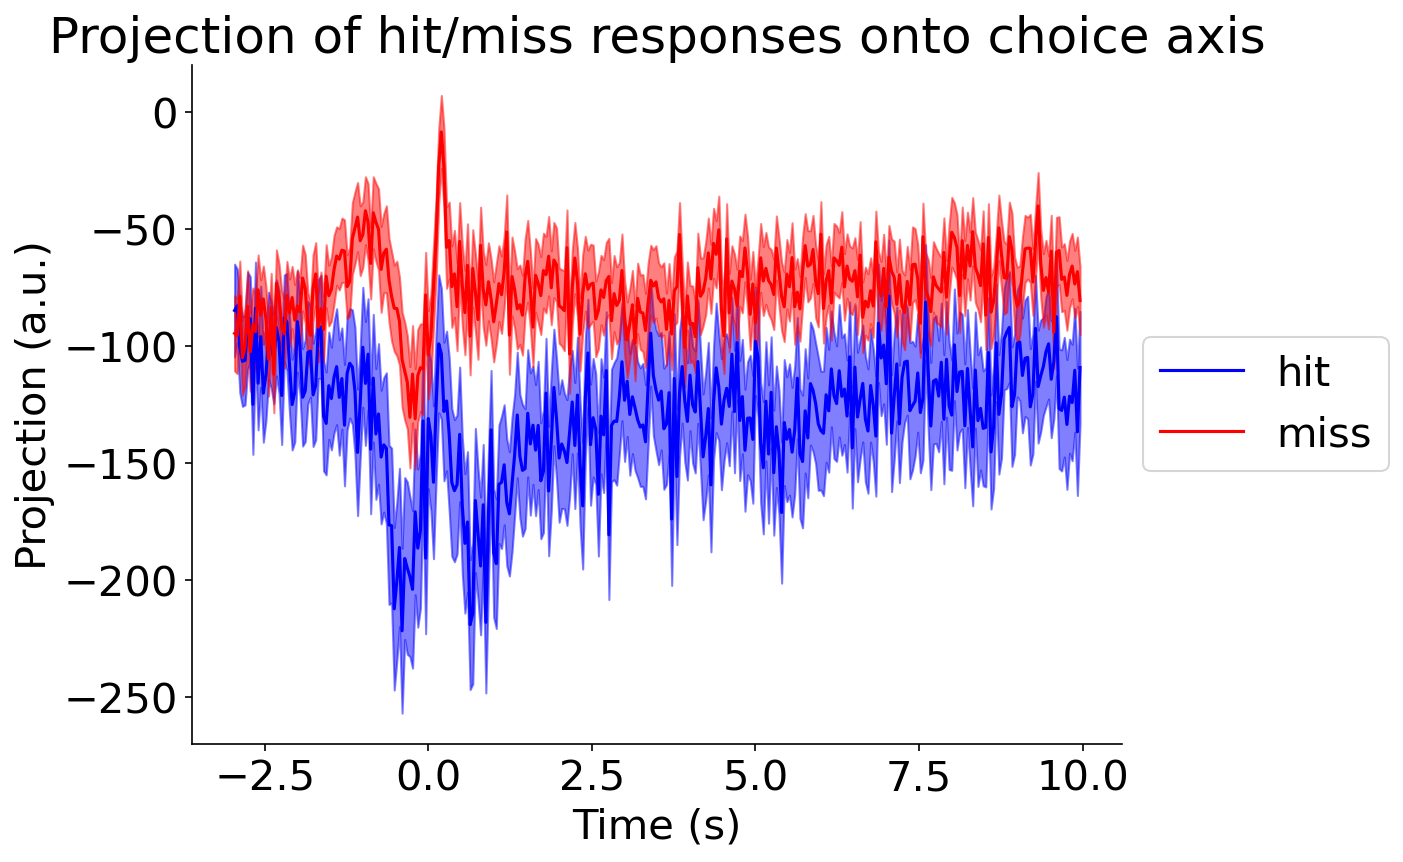

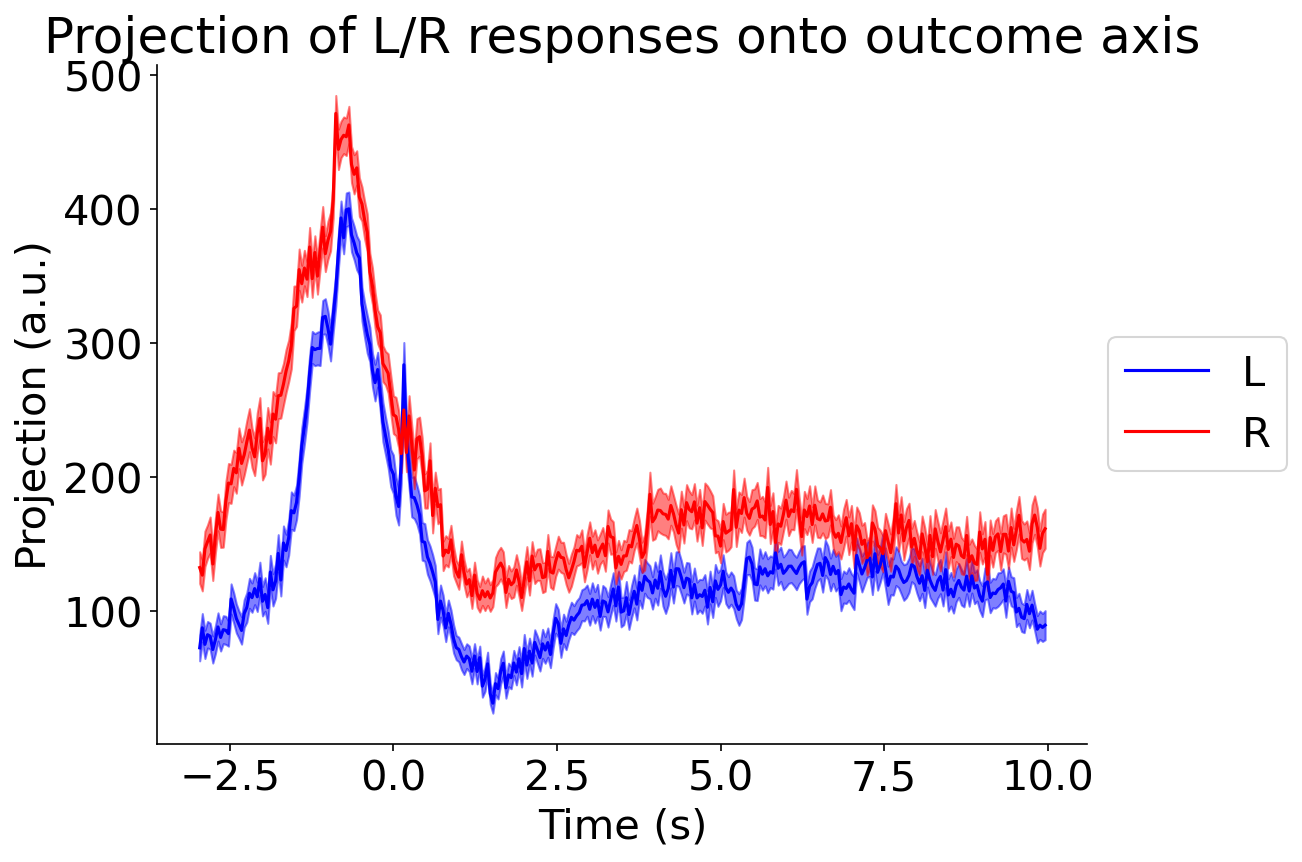

In [27]:
def get_coding_axis(pop_psth_1, pop_psth_2):

    pop_psth_1_avg = np.average(pop_psth_1, axis=1)
    pop_psth_2_avg = np.average(pop_psth_2, axis=1)
    pop_psth_diff_12 = pop_psth_1_avg - pop_psth_2_avg
    pop_psth_diff_12_avg = np.average(pop_psth_diff_12, axis=1)

    return pop_psth_diff_12_avg


def get_coding_axis_projection(pop_psth, coding_axis):
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_axis)
    proj_avg = np.average(proj, axis=0)
    proj_std = np.std(proj, axis=0)
    proj_sem = proj_std / np.sqrt(proj.shape[0])

    return proj_avg, proj_sem
    

def plot_projection_coding_axis(proj_1, proj_1_sem, proj_2, proj_2_sem, bins,
                                proj_1_source_name, proj_2_source_name, axis_name):
    fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
    plt.plot(bins, proj_1, 'b-', label=proj_1_source_name)
    plt.fill_between(bins, proj_1-proj_1_sem, proj_1+proj_1_sem,
                    alpha=0.5, color='b')
    plt.plot(bins, proj_2, 'r-', label=proj_2_source_name)
    plt.fill_between(bins, proj_2-proj_2_sem, proj_2+proj_2_sem,
                    alpha=0.5, color='r')
    plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
    plt.xlabel('Time (s)')
    plt.ylabel('Projection (a.u.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    plt.show()


print(pop_psth_R.shape)
print(pop_psth_L.shape)

choice_coding_axis = get_coding_axis(pop_psth_L, pop_psth_R)
L_proj_choice_axis, L_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_L, choice_coding_axis)
R_proj_choice_axis, R_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_R, choice_coding_axis)
plot_projection_coding_axis(L_proj_choice_axis, L_proj_choice_axis_sem, R_proj_choice_axis, R_proj_choice_axis_sem, bins,
                            'L', 'R', 'choice')

outcome_coding_axis = get_coding_axis(pop_psth_hit, pop_psth_miss)
hit_proj_outcome_axis, hit_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_hit, outcome_coding_axis)
miss_proj_outcome_axis, miss_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_miss, outcome_coding_axis)
plot_projection_coding_axis(hit_proj_outcome_axis, hit_proj_outcome_axis_sem, miss_proj_outcome_axis, miss_proj_outcome_axis_sem, bins,
                            'hit', 'miss', 'outcome')

hit_proj_choice_axis, hit_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_hit, choice_coding_axis)
miss_proj_choice_axis, miss_proj_choice_axis_sem = get_coding_axis_projection(pop_psth_miss, choice_coding_axis)
plot_projection_coding_axis(hit_proj_choice_axis, hit_proj_choice_axis_sem, miss_proj_choice_axis, miss_proj_choice_axis_sem, bins,
                            'hit', 'miss', 'choice')

L_proj_outcome_axis, L_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_L, outcome_coding_axis)
R_proj_outcome_axis, R_proj_outcome_axis_sem = get_coding_axis_projection(pop_psth_R, outcome_coding_axis)
plot_projection_coding_axis(L_proj_outcome_axis, L_proj_outcome_axis_sem, R_proj_outcome_axis, R_proj_outcome_axis_sem, bins,
                            'L', 'R', 'outcome')

## dsPCA

In [6]:
# fetch independent variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable
                    & keys2trials_all
                    & {'model_id': 10})

# fetch independent variables?
df = util._get_unit_independent_variable(keys2units[0], model_id=10)
df

,trial,subject_id,session,model_id,left_,right_,contra_,ipsi_,left_action_value,right_action_value,...,ipsi_choice_kernel,relative_action_value_lr,relative_action_value_ic,total_action_value,choice,choice_lr,choice_ic,outcome,reward,rpe
0,1,473361,47,10,left,right,left,right,0.455350,0.000000,...,NaN,-0.45535,0.45535,0.45535,left,0,1,hit,1,1.0
1,2,473361,47,10,left,right,left,right,0.703356,0.000000,...,NaN,-0.703356,0.703356,0.703356,left,0,1,hit,1,0.54465
2,3,473361,47,10,left,right,left,right,0.383083,0.000000,...,NaN,-0.383083,0.383083,0.383083,left,0,1,miss,0,-0.703356
3,4,473361,47,10,left,right,left,right,0.208646,0.000000,...,NaN,-0.208646,0.208646,0.208646,left,0,1,miss,0,-0.383083
4,5,473361,47,10,left,right,left,right,0.113639,0.000000,...,NaN,-0.113639,0.113639,0.113639,left,0,1,miss,0,-0.208646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,503,473361,47,10,left,right,left,right,0.163383,0.000171,...,NaN,-0.163211,0.163211,0.163554,right,1,0,miss,0,-0.000314
417,504,473361,47,10,left,right,left,right,0.088986,0.000093,...,NaN,-0.088893,0.088893,0.08908,left,0,1,miss,0,-0.163383
418,507,473361,47,10,left,right,left,right,0.048466,0.455401,...,NaN,0.406934,-0.406934,0.503867,right,1,0,hit,1,0.999907
419,508,473361,47,10,left,right,left,right,0.026397,0.248034,...,NaN,0.221637,-0.221637,0.274431,right,1,0,miss,0,-0.455401


In [7]:
import pandas as pd

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left'].sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right'].sort_values(by=['trial'])

# delta_Q
delta_Q = df_Q_left['action_value'].values - df_Q_right['action_value'].values
print('delta_Q: {}'.format(delta_Q.shape))

# sigma_Q
sigma_Q = df_Q_left['action_value'].values + df_Q_right['action_value'].values
print('sigma_Q: {}'.format(sigma_Q.shape))

# choice_Q
trials_all.fetch('water_port').shape
left_trial_ind = np.where(trials_all.fetch('water_port')=='left')
# print(left_trial_ind[0].shape)
right_trial_ind = np.where(trials_all.fetch('water_port')=='right')
# print(right_trial_ind[0].shape)

left_trial_indicator = np.zeros_like(trials_all.fetch('water_port'))
left_trial_indicator[left_trial_ind] = 1
right_trial_indicator = np.zeros_like(trials_all.fetch('water_port'))
right_trial_indicator[right_trial_ind] = 1

left_choice_Q = df_Q_left['action_value'].values * left_trial_indicator
right_choice_Q = df_Q_right['action_value'].values * right_trial_indicator
choice_Q = left_choice_Q + right_choice_Q
print('choice_Q: {}'.format(choice_Q.shape))



delta_Q: (408,)
sigma_Q: (408,)
choice_Q: (408,)


In [8]:
from dspca.dspca import dsPCA

In [9]:
# prepare data matrix for dsPCA
# data ([# of observations] X [# of dimensions to be reduced]) 
# targets ([# of observations] X [# of targets])

# for isi: take only time < 2.5s
time_limit = 2.5
data = pop_psth_all[:, :, np.where(bins < time_limit)[0]]
data = np.average(data, axis=2).transpose()
print(data.shape)

targets_list = [delta_Q, sigma_Q, choice_Q]
targets = np.vstack(targets_list).transpose()
print(targets.shape)


(408, 58)
(408, 3)


In [10]:
[projection_target_subspace, projection_targetfree_subspace, ax_targets, ax_targetfree, 
 target_subspace_signal, targetfree_subspace_signal, target_subspace_var, targetfree_subspace_var,
 total_var, dot_target_ax] = dsPCA(data=data, targets=targets)


In [42]:
print(target_subspace_var)

[161.87520615 180.19302526 134.17864562]


In [44]:
print(targetfree_subspace_var[:10])

[73.1215182  57.17202329 32.97617854 27.59299259 25.00225897 22.30181227
 17.87407689 16.64755664 14.50671308 13.60444213]


In [41]:
print(projection_target_subspace.shape)
print(projection_targetfree_subspace.shape)

(408, 3)
(408, 55)


In [47]:
print(ax_targets.shape)
print(ax_targetfree.shape)

(58, 3)
(58, 55)


In [13]:
pop_psth_all.shape

(58, 408, 324)

No handles with labels found to put in legend.


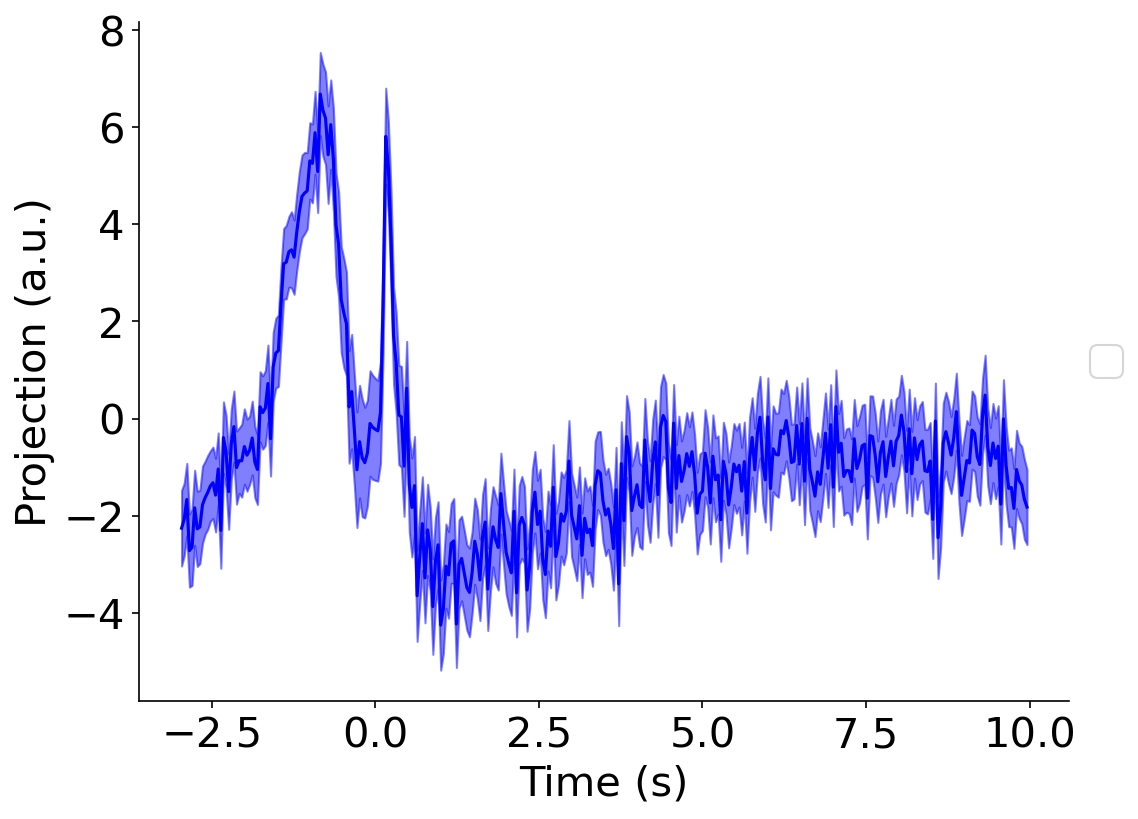

In [32]:
def get_dspca_axis_projection(pop_psth, coding_axis):
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_axis)
    proj_avg = np.average(proj, axis=0)
    proj_std = np.std(proj, axis=0)
    proj_sem = proj_std / np.sqrt(proj.shape[0])

    return proj_avg, proj_sem


proj_avg, proj_sem = get_dspca_axis_projection(pop_psth_all, ax_targets[:, 0])

fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
plt.plot(bins, proj_avg, 'b-')
plt.fill_between(bins, proj_avg-proj_sem, proj_avg+proj_sem,
                alpha=0.5, color='b')
# plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
plt.xlabel('Time (s)')
plt.ylabel('Projection (a.u.)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
plt.show()

In [30]:
sorted_ind_delta_Q = np.argsort(delta_Q)
print(sorted_ind_delta_Q.shape)

n_quantile = int(delta_Q.shape[0]/ 5)
pop_psth_delta_Q_low20 = pop_psth_all[:, sorted_ind_delta_Q[:n_quantile], :]
pop_psth_delta_Q_top20 = pop_psth_all[:, sorted_ind_delta_Q[n_quantile*(-1):], :]

(408,)


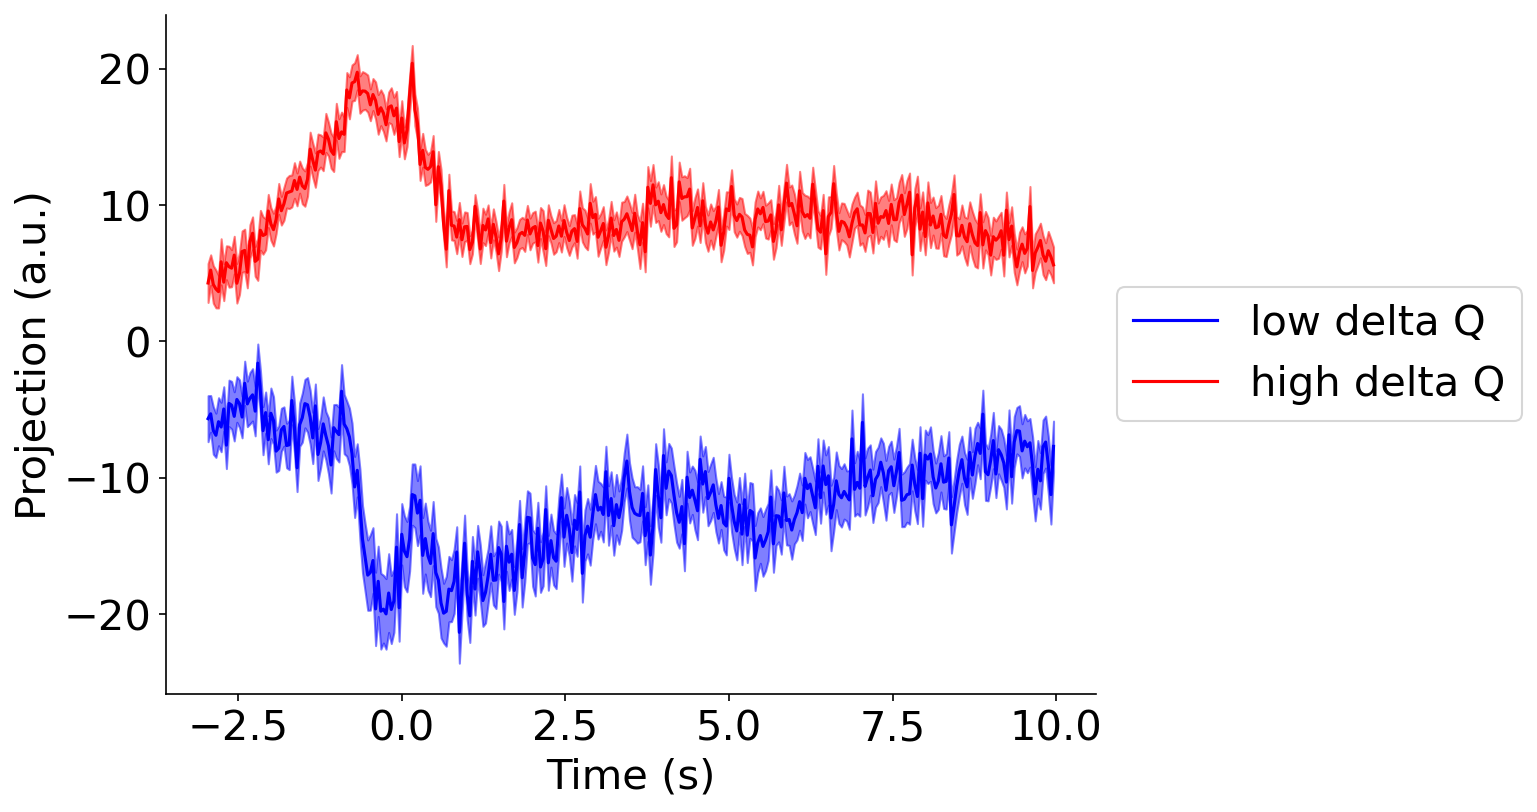

In [31]:
proj_avg_low20, proj_sem_low20 = get_dspca_axis_projection(pop_psth_delta_Q_low20, ax_targets[:, 0])
proj_avg_top20, proj_sem_top20 = get_dspca_axis_projection(pop_psth_delta_Q_top20, ax_targets[:, 0])

fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
plt.plot(bins, proj_avg_low20, 'b-', label='low delta Q')
plt.fill_between(bins, proj_avg_low20-proj_sem_low20, proj_avg_low20+proj_sem_low20,
                alpha=0.5, color='b')
plt.plot(bins, proj_avg_top20, 'r-', label='high delta Q')
plt.fill_between(bins, proj_avg_top20-proj_sem_top20, proj_avg_top20+proj_sem_top20,
                alpha=0.5, color='r')
# plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
plt.xlabel('Time (s)')
plt.ylabel('Projection (a.u.)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
plt.show()

In [21]:
pop_psth_all.shape

(58, 408, 324)

## PCA visualization

In [ ]:
pop_psth_counts = np.average(pop_psth_all, axis=2)

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

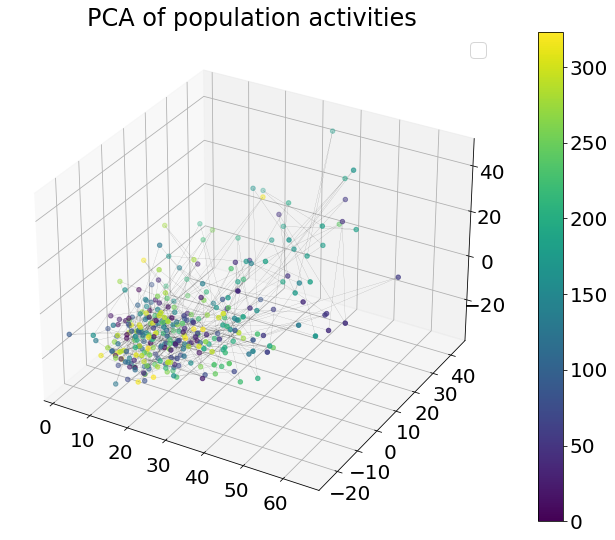

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

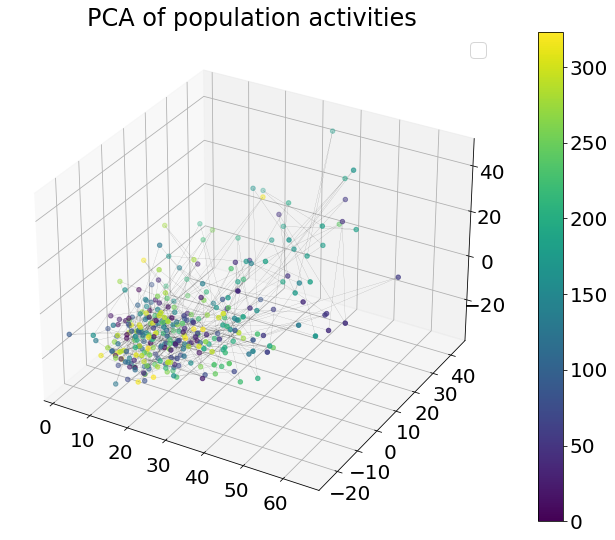

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def pop_counts_pca(pop_psth_avg, cluster_crtieria, verbose=True):
    
    colors = ["navy", "turquoise"]
    lw = 0.01
    
    if cluster_crtieria == 'water_port':
        target_names = ['L', 'R']
        selected_indices = [np.where(np.in1d(all_trial_ind, left_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, right_trial_ind))[0]]
    elif cluster_crtieria == 'outcome':
        target_names = ['hit', 'miss']
        selected_indices = [np.where(np.in1d(all_trial_ind, hit_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, miss_trial_ind))[0]]
    else:
        raise ValueError('cluster_criteria ill defined')

    pca = PCA(n_components=3)
    X = pop_psth_avg.transpose()   # (trial, units)
    pca.fit(X)
    print(pca.components_)
    print(pca.explained_variance_)
    X_pca = pca.transform(X)     # (trial, n_feature)

    X_pca_all_time = []
    for i in range(pop_psth_all.shape[2]):
        _X_pca = pca.transform(pop_psth_all[:, :, i].transpose())
        X_pca_all_time.append(_X_pca)
    X_pca_all_time = np.array(X_pca_all_time)

    if verbose:
        print('reduced matrix shape: {}'.format(X_pca_all_time.shape))
        print(X_pca_all_time[:, 0, 0])
        # Percentage of variance explained for each components
        print("explained variance ratio (first two components): %s" % str(pca.explained_variance_ratio_))

    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(111, projection='3d')
    # ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=48, azim=134)
    t = np.arange(X_pca_all_time.shape[0])

    plot_ind = 9
    p = ax.scatter(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
                   c=t, cmap='viridis')
    ax.plot(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
            'k--', lw=0.1)
    
    # for color, ind, target_name in zip(colors, selected_indices, target_names):
    #     ax.scatter(X_pca_all_time[:, ind, 0], X_pca_all_time[:, ind, 1], X_pca_all_time[:, ind, 2],
    #                color=color, alpha=0.8, lw=lw, label=target_name)
    plt.legend(loc="best")
    fig.colorbar(p)
    plt.title("PCA of population activities")
    plt.show()

pop_counts_pca(pop_psth_counts, 'outcome')
pop_counts_pca(pop_psth_counts, 'water_port')